In [1]:
import torch
import albumentations as A
from albumentations.pytorch.transforms import img_to_tensor
import cv2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path

In [4]:
from ternausnet.ternausnet import UNet11
import draw
import img_transformations as img_t
import dataset

In [5]:
if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    device = torch.device("cuda:0")
else:
    from torch import FloatTensor, LongTensor
    device = torch.device("cpu")

In [6]:
# load model
model = UNet11(pretrained=False)

checkpoint = torch.load(Path('../../trained_models/street_leaves_unet11.pt'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
model.eval()

UNet11(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

# Predictions on train data

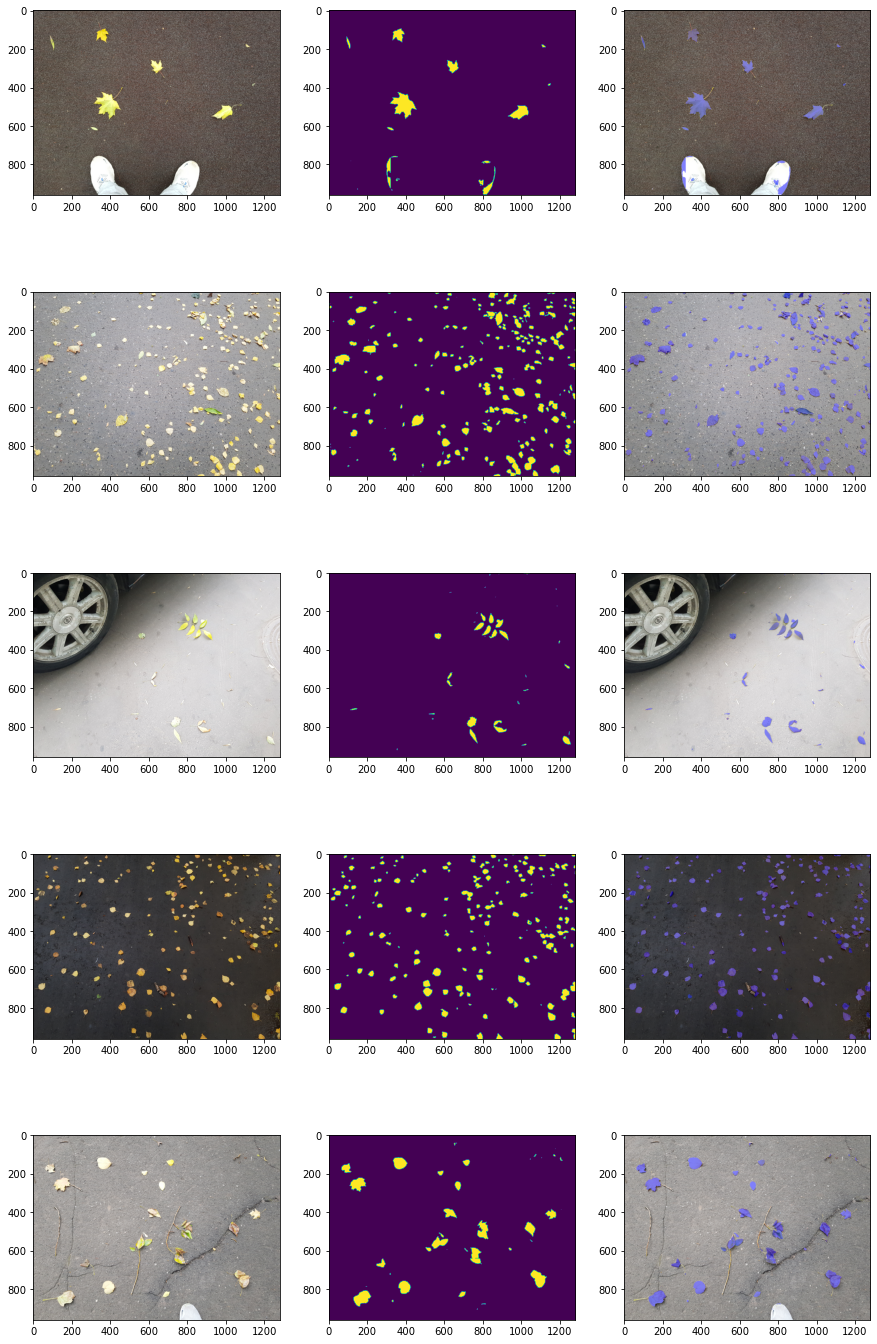

In [17]:
def get_resized_parts_img(img_path, mask):
    real_image = cv2.imread(str(img_path))
    real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
    
    img_pieces = img_t.separate_image_on_steps(real_image, 3, 4)
    
    resizer = A.Resize(320,320)
    for i in range(len(img_pieces)):
        img_pieces[i] = torch.Tensor(resizer(image=img_pieces[i])['image'])
    
    img, mask = img_t.gather_image_from_pieces(img_pieces, 3, 4, list(mask.cpu()))
    img = img.numpy().astype(np.uint8)
    mask = mask[0].cpu().numpy()
    
    return img, mask

def predict_and_print_imgs(img_paths):
    train_data = dataset.LeavesDataset(img_paths, transform=img_t.evaluate_transform(is_crop=False),
                                   mode='eval', steps_row=3, steps_col=4)
    
    fig, ax = plt.subplots(len(img_paths),3,figsize=(15, 5 * len(img_paths)))
    with torch.no_grad():
        model.eval()
        for i in range(len(img_paths)):
            mask = model(train_data[i][0].to(device))
            img, mask = get_resized_parts_img(img_paths[i], mask)

            ax[i][0].imshow(img)
            ax[i][1].imshow(mask > 0)
            ax[i][2].imshow(draw.mask_overlay(img, mask > 0, resize=(960, 1280)))
            
            extent = ax[i][2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'{i}_prediction.png', bbox_inches=extent, facecolor = 'white', dpi=1000)
    
    plt.show()

root = Path('../data/my_leaves/archive/')

img_names = ['2021-09-26 17-12-33.jpg', '2021-09-19 15-26-02.jpg', '2021-09-19 15-50-39.jpg',
             '2021-09-26 17-15-45.jpg', '2021-09-19 15-27-51.jpg']
img_paths = [root / 'images/' / img_path for img_path in img_names]

predict_and_print_imgs(img_paths)

# Predictions on test data

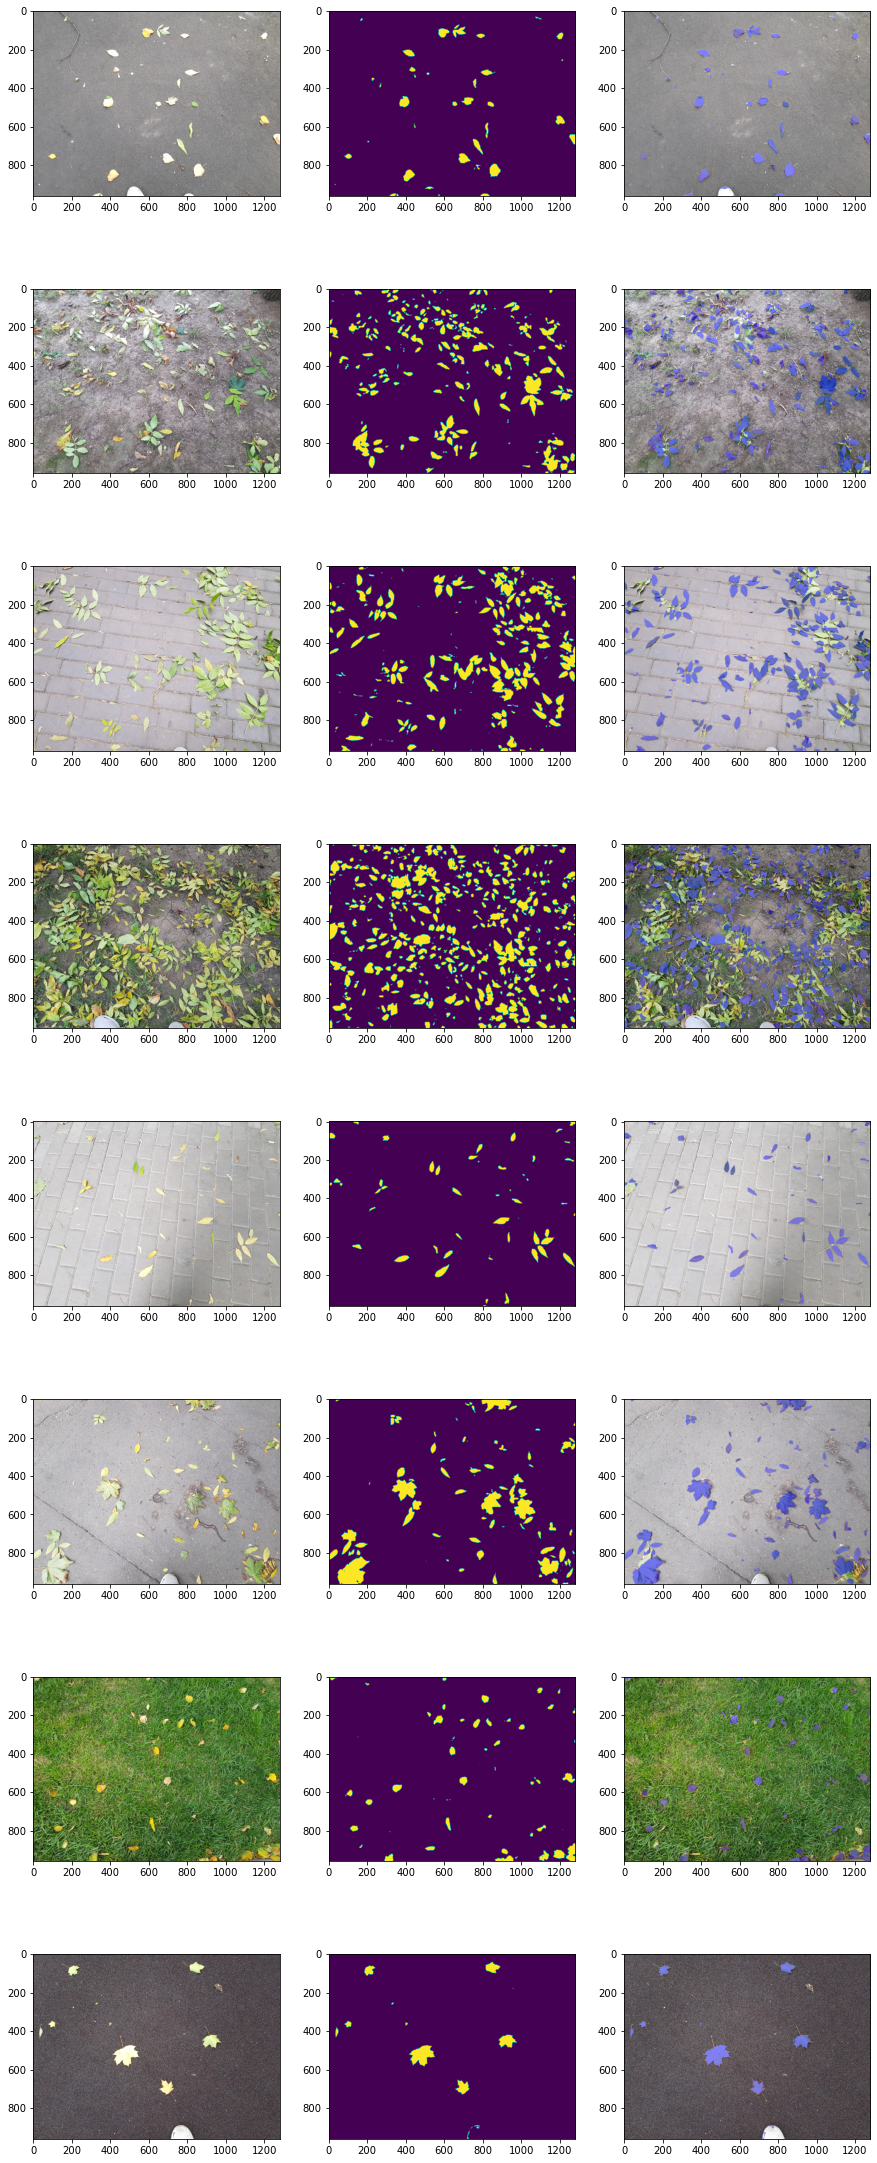

In [18]:
root = Path('../test/ds0/img/')

img_names = ['2021-09-19 15-29-56.jpg', '2021-09-19 15-35-48.jpg', '2021-09-19 15-37-21.jpg',
             '2021-09-19 15-38-41.jpg', '2021-09-19 15-41-31.jpg', '2021-09-19 15-45-14.jpg',
            '2021-09-19 15-51-36.jpg', '2021-09-26 17-12-43.jpg']

img_paths = [root / img_path for img_path in img_names]

predict_and_print_imgs(img_paths)